In [1]:
from matplotlib import pyplot as plt 

In [2]:
import json

In [3]:
import re

In [4]:
import numpy as np

In [5]:
def bucket(x, size):
    l = len(x)
    buckets = []
    i = 0
    while i < l:
        buckets.append(sum(x[i:i+size])/len(x[i:i+size]))
        i+=size
    return buckets

In [6]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [7]:
class LogReader():
    def __init__(self, filename, keys):
        self.file = open(f'{filename}')
        self.keys = set(keys)
        self.matches = {}
        for key in keys:
            self.matches[key]=[]
    
    def grab(self):
        line = next(self.file, None)
        while line:
            split = line.strip().split('=')
            if len(split)==2:
                query = split[0]
                value = float(split[1])
                if query in self.keys:
                    self.matches[query].append(value)
            line = next(self.file, None)
        return self.matches

In [8]:
tasks = [
    ('atac_region', 'gene'),
    ('gene', 'atac_region'),
    ('gene', 'protein_name'),
    ('protein_name', 'gene'),
]

In [9]:
base_keys = [
    'train zero one loss',
    'train value loss',
    'train prediction loss',
    'validation zero one loss',
    'validation value loss',
    'validation prediction loss',
]

keys = []
for key in base_keys:
    for task in tasks:
        keys.append(f'{key} {task}')

In [10]:
keys += [
    'Batch',
    'Epoch',
]

#### Bucket Size

In [11]:
bucket_size = 10

In [12]:
readers = {}
matches = {}

#### Timestamp of run

In [13]:
timestamps = [
    '20220709-1339', # SAGE 5 layers
#     '20220709-1340',
    '20220824-1408', # SAGE, 3 layers
    '20220824-1415', # GAT 
]
files = [f'logs/train_earl_{tmstp}.log' for tmstp in timestamps]

In [14]:
for file in files:
    if file not in readers:
        readers[file] = LogReader(file, keys)
        matches = readers[file].grab()

## Select File

In [30]:
idx = 2

## Get matching log lines

In [31]:
file = files[idx]
matches = readers[file].grab()

## Parameters of this run

In [32]:
import json
from pprint import pprint

In [33]:
params = json.load(open(f'logs/earl_params_{timestamps[idx]}.json'))
pprint(params)

{'atac_ones_weight': 1,
 'checkpoint': 25,
 'device': 'cuda:1',
 'gene_ones_weight': 1,
 'layers': [['SAGEConv', {'out_channels': 32}],
            ['SAGEConv', {'out_channels': 32}],
            ['SAGEConv', {'out_channels': 32}]],
 'lr': 0.001,
 'n_steps': 30000,
 'out_mlp': {'bias': True,
             'dim_in': 32,
             'dim_inner': 512,
             'dim_out': 1,
             'num_layers': 3},
 'train_batch_size': 500,
 'validation_batch_size': 100}


In [34]:
batch_size = params['train_batch_size']

## Current Batch

In [35]:
batch = int(matches['Batch'][-1])
batch

91

## Num examples seen

In [36]:
batch*batch_size

45500

## Training loss

In [37]:
from matplotlib import cm

('atac_region', 'gene') 0.3909
('gene', 'atac_region') 0.4338
('gene', 'protein_name') 0.5477
('protein_name', 'gene') 0.4190


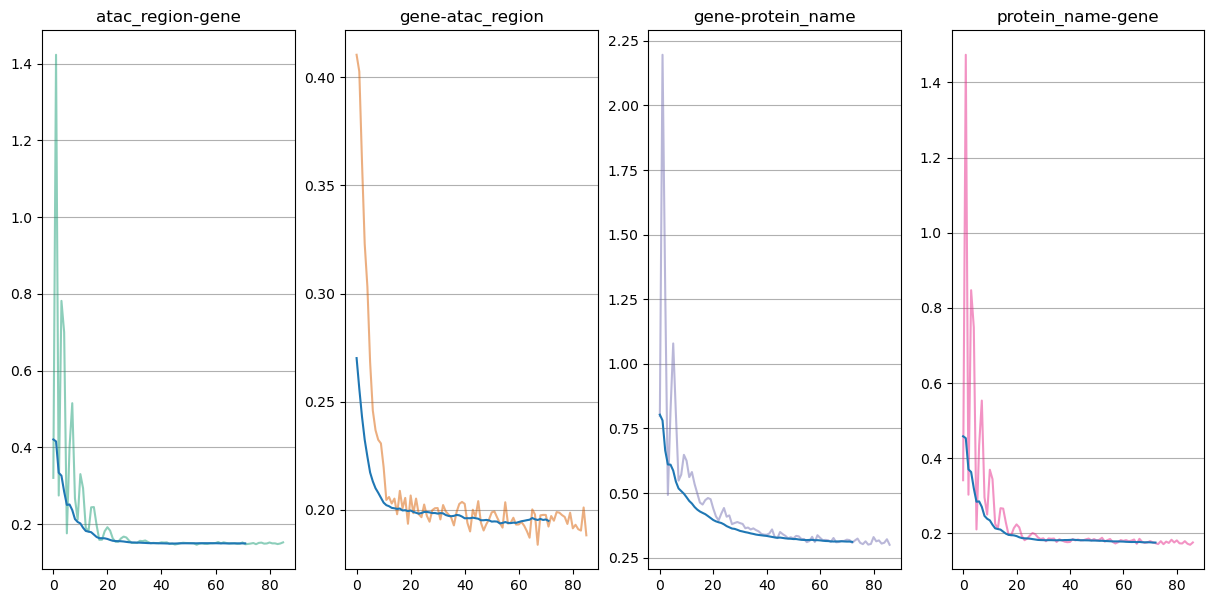

In [38]:
fig,ax = plt.subplots(1, 4, figsize=(15,7))

cmap = cm.Dark2

start = 5
width = 15

for i,task in enumerate(tasks):
    training_loss = matches[f'train prediction loss {task}']
    color = list(cmap(i))
    color2 = list(color) 
    color2[3] = .5
    ax[i].plot(training_loss[start:], label=f'{task[0]}-{task[1]}', c=color2)
    ax[i].plot(moving_average(training_loss[start:],width))
    ax[i].grid(axis='y')
    ax[i].set_title(f'{task[0]}-{task[1]}')
#     ax.plot(bucket_steps, bucket(training_loss[batch_size:],5), c=color)
    print(task, f'{np.sqrt(training_loss[-1]):.4f}')
# _=ax[0].legend()


## Validation Loss

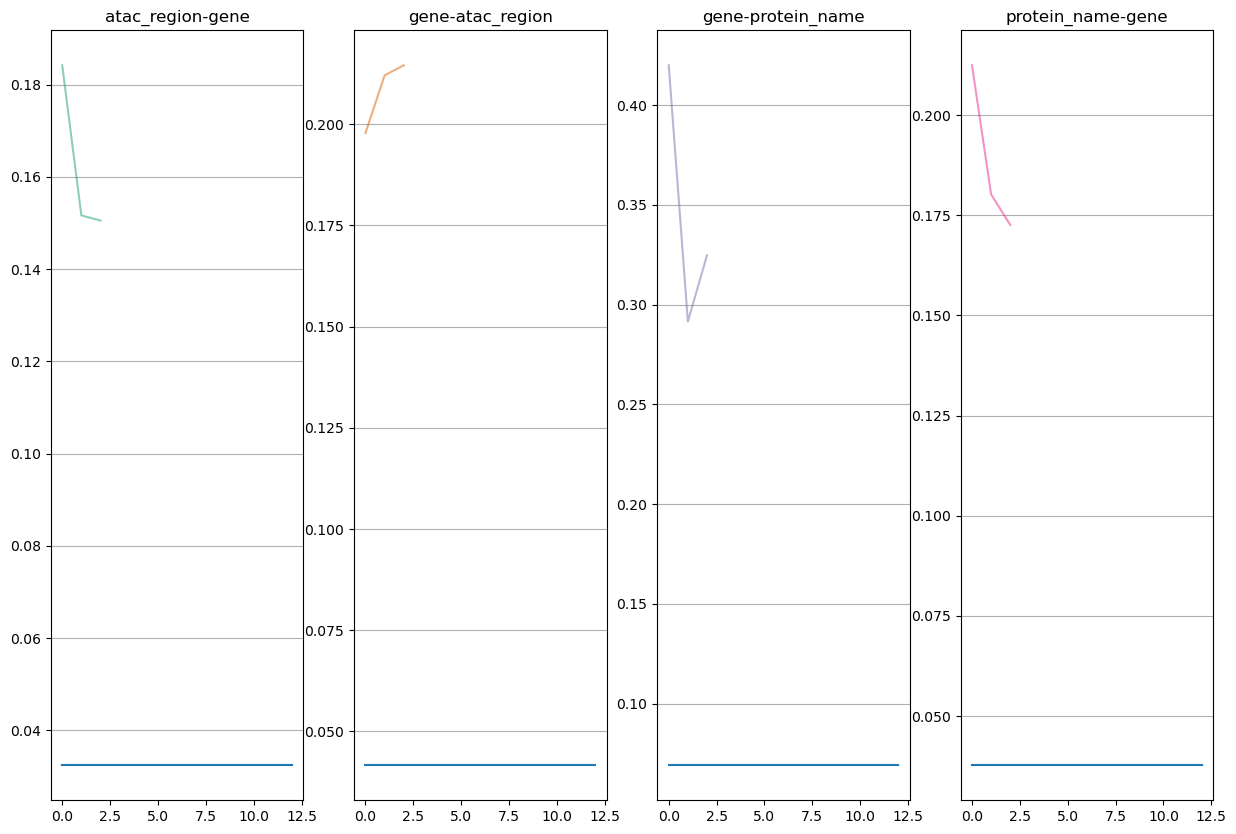

In [39]:
fig,ax = plt.subplots(1,4, figsize=(15,10))

for i,task in enumerate(tasks):
    validation_loss = matches[f'validation prediction loss {task}']
    color = list(cmap(i))
    color2 = list(color) 
    color2[3] = .5
    ax[i].plot(validation_loss[1:], label=f'{task[0]}-{task[1]}', c=color2)
    ax[i].plot(moving_average(validation_loss[1:],width))
    ax[i].grid(axis='y')
    ax[i].set_title(f'{task[0]}-{task[1]}')


In [40]:
for i,task in enumerate(tasks):
    validation_loss = matches[f'validation prediction loss {task}']
    print(task, f'{np.sqrt(validation_loss[-1]):.3f}')


('atac_region', 'gene') 0.388
('gene', 'atac_region') 0.463
('gene', 'protein_name') 0.570
('protein_name', 'gene') 0.415


### Neurips results (RMSE)

atac gene = .22

gene atac = .17

gene protein = .39

protein gene = .32

## Sample predictions

In [41]:
import re

In [42]:
batch_re = re.compile('^batch')

In [43]:
import time

In [44]:
prediction_file = open(f'logs/train_earl_prediction_sample_{timestamps[idx]}.log')

ls = []

for i,line in enumerate(prediction_file):
    l = line.strip()
    if batch_re.match(l) and i%5==0:
        ls.append(l)
    elif not batch_re.match(l):
        ls.append(l)
        
for l in ls:
    time.sleep(.005)
    print(l)
    time.sleep(.01)
    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

batch 75 47     pred,y:   0.049 0.000
batch 75 52     pred,y:   0.105 0.000
batch 75 57     pred,y:   0.143 0.000
batch 75 62     pred,y:   0.100 0.000
batch 75 67     pred,y:   0.134 0.000
batch 75 72     pred,y:   0.096 0.000
batch 75 77     pred,y:   0.109 0.000
batch 75 82     pred,y:   0.108 0.000
batch 75 87     pred,y:   0.119 0.000
batch 75 92     pred,y:   0.111 0.000
batch 75 97     pred,y:   0.136 0.000
batch 75 102    pred,y:   0.109 0.000
batch 75 107    pred,y:   0.114 0.000
batch 75 112    pred,y:   0.140 0.000
batch 75 117    pred,y:   0.107 0.000
batch 75 122    pred,y:   0.125 0.000
batch 75 127    pred,y:   0.137 0.000
batch 75 132    pred,y:   0.195 0.000
batch 75 137    pred,y:   0.123 0.000
batch 75 142    pred,y:   0.112 0.000
batch 75 147    pred,y:   0.144 0.000
batch 75 152    pred,y:   0.116 0.000
batch 75 157    pred,y:   0.138 0.000
batch 75 162    pred,y:   0.136 0.000
batch 75 167    pred,y:   0.141 0.000
batch 75 172    pred,y:   0.183 0.000
batch 75 177